# Combining data

#### Extracting pdf data (I am the spooker)

In [28]:
import pdfplumber
import re
import pandas as pd

# STEP 1 - Read in Tweets from PDF
pdf_path = "data\Twitter-iamthespookster-2019-08-04 (1).pdf"
with pdfplumber.open(pdf_path) as pdf:
    raw_data = "\n".join([page.extract_text() for page in pdf.pages if page.extract_text()])

# STEP 2 - Extract Tweets from Raw Data
dat = raw_data.split("\n")
dat = dat[4:]  # Remove first four lines (heading/whitespace)

# Find and remove line breaks
LBs = [i for i, line in enumerate(dat) if line == ""]
dat = [line for i, line in enumerate(dat) if i not in LBs]

# Find the Line Containing the Source of Each Tweet
source_line = [i for i, line in enumerate(dat) if "(Source:" in line]

# Extract Tweet, Date, Source from Content
tweets, dates, sources = [], [], []
start = 0
for i in source_line:
    tweet_in = dat[start:i+1]
    tweets.append(" ".join(tweet_in[:-2]))
    dates.append(tweet_in[-2])
    sources.append(tweet_in[-1])
    start = i + 1

data = pd.DataFrame({"tweet": tweets, "date": dates, "source": sources})

# STEP 3 - Extract Data from Tweet
url_pattern = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")

data["RT"] = data["tweet"].str.startswith("RT ")
data["tweet"] = data["tweet"].str.replace(r"^RT ", "", regex=True)

data["user_tag"] = data["tweet"].str.contains("@")
data["account"] = data["tweet"].apply(lambda x: ",".join(re.findall(r"@\w+", x)))
data["tweet"] = data["tweet"].apply(lambda x: re.sub(r"@\w+|:", "", x))

data["ext_link"] = data["tweet"].str.contains("http")
data["link"] = data["tweet"].apply(lambda x: ",".join(url_pattern.findall(x)))
data["tweet"] = data["tweet"].apply(lambda x: url_pattern.sub("", x))

print(data.head())
print(data.shape[0])

                                               tweet                  date  \
0                                                     Mar 9, 2019, 4:16 PM   
1                                                Why  Mar 9, 2019, 4:28 PM   
2   Today in “Manosphere Grift or Terrorist Recru...  Mar 9, 2019, 4:43 PM   
3   How can anyone see this as a good luck charm?...  Mar 9, 2019, 4:46 PM   
4                                  Hamms is good tho  Mar 9, 2019, 5:44 PM   

                                              source     RT  user_tag  \
0  (Source: https://twitter.com/iamthespookster/s...  False     False   
1  (Source: https://twitter.com/iamthespookster/s...  False      True   
2  (Source: https://twitter.com/iamthespookster/s...   True      True   
3  (Source: https://twitter.com/iamthespookster/s...   True      True   
4  (Source: https://twitter.com/iamthespookster/s...  False      True   

            account  ext_link link  
0                       False       
1  @LetsJetTogethe

### Extracting excel data

In [29]:
import pandas as pd

# Read CSV without headers and assign column names
df2 = pd.read_excel('data\Dataset.xlsx', names=['Posts'])

print(df2.head())

                                               Posts
0  Mommy said not to talk to strangers..but she's...
1  1.I was immune to getting hurt/killed/infected...
2  I mean terrorist attacks happen all the time. ...
3  As a god, it would be my responsibility not to...
4  I am going to grab a knife and shove it in the...


### Combine into 1 df

In [30]:
#combine the 2 data

df1_selected = data[['tweet']].rename(columns={'tweet': 'Posts'})

df = pd.concat([df1_selected,df2], ignore_index = True)
df['Mass shooter post']=1

print(df)

                                                  Posts  Mass shooter post
0                                                                        1
1                                                   Why                  1
2      Today in “Manosphere Grift or Terrorist Recru...                  1
3      How can anyone see this as a good luck charm?...                  1
4                                     Hamms is good tho                  1
...                                                 ...                ...
3851  I'm getting over much of the problems I've had...                  1
3852  Bleys, thanks for your uplifting message.\n\nI...                  1
3853  I'm a fan of zombie film's, have been for year...                  1
3854  Hello All...\n\nI came across this place on th...                  1
3855  Thank's for the friendly welcome, I'm going to...                  1

[3856 rows x 2 columns]


# EDA

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

In [14]:
df['Length'] = df['Posts'].str.len()
df.head(10)

,Posts,Mass shooter post,Length
0,,1,0
1,Why,1,4
2,Today in “Manosphere Grift or Terrorist Recru...,1,121
3,How can anyone see this as a good luck charm?...,1,94
4,Hamms is good tho,1,18
5,I want to get in on the grift of being paid t...,1,84
6,⠀ ⠀ ⠀ 🤠 🕯 🕯 🕯 🕯 🕯 🕯 # 🕯 🕯 # 🕯 🕯 🕯 🕯 👢 👢 howdy...,1,82
7,"""Please, if anyone can hear me"" https//t.co/R...",1,55
8,Piling in the jalopy with the bros for an unf...,1,124
9,What did The Red Cross do with half billion d...,1,98


In [16]:
def word_count(posts):
    post_list = posts.split()
    return len(post_list)

df['Word_count'] = df['Posts'].apply(word_count)
df.head(10)

,Posts,Mass shooter post,Length,Word_count
0,,1,0,0
1,Why,1,4,1
2,Today in “Manosphere Grift or Terrorist Recru...,1,121,19
3,How can anyone see this as a good luck charm?...,1,94,16
4,Hamms is good tho,1,18,4
5,I want to get in on the grift of being paid t...,1,84,17
6,⠀ ⠀ ⠀ 🤠 🕯 🕯 🕯 🕯 🕯 🕯 # 🕯 🕯 # 🕯 🕯 🕯 🕯 👢 👢 howdy...,1,82,27
7,"""Please, if anyone can hear me"" https//t.co/R...",1,55,7
8,Piling in the jalopy with the bros for an unf...,1,124,22
9,What did The Red Cross do with half billion d...,1,98,15


In [18]:
df['mean_word_length'] = df['Posts'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df.head(10)

,Posts,Mass shooter post,Length,Word_count,mean_word_length
0,,1,0,0,NaN
1,Why,1,4,1,3.000000
2,Today in “Manosphere Grift or Terrorist Recru...,1,121,19,5.368421
3,How can anyone see this as a good luck charm?...,1,94,16,4.875000
4,Hamms is good tho,1,18,4,3.500000
5,I want to get in on the grift of being paid t...,1,84,17,3.941176
6,⠀ ⠀ ⠀ 🤠 🕯 🕯 🕯 🕯 🕯 🕯 # 🕯 🕯 # 🕯 🕯 🕯 🕯 👢 👢 howdy...,1,82,27,2.037037
7,"""Please, if anyone can hear me"" https//t.co/R...",1,55,7,6.857143
8,Piling in the jalopy with the bros for an unf...,1,124,22,4.636364
9,What did The Red Cross do with half billion d...,1,98,15,5.533333


In [20]:
df['mean_sent_length'] = df['Posts'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
df.head(10)

,Posts,Mass shooter post,Length,Word_count,mean_word_length,mean_sent_length
0,,1,0,0,NaN,NaN
1,Why,1,4,1,3.000000,4.000000
2,Today in “Manosphere Grift or Terrorist Recru...,1,121,19,5.368421,121.000000
3,How can anyone see this as a good luck charm?...,1,94,16,4.875000,30.666667
4,Hamms is good tho,1,18,4,3.500000,18.000000
5,I want to get in on the grift of being paid t...,1,84,17,3.941176,84.000000
6,⠀ ⠀ ⠀ 🤠 🕯 🕯 🕯 🕯 🕯 🕯 # 🕯 🕯 # 🕯 🕯 🕯 🕯 👢 👢 howdy...,1,82,27,2.037037,40.500000
7,"""Please, if anyone can hear me"" https//t.co/R...",1,55,7,6.857143,55.000000
8,Piling in the jalopy with the bros for an unf...,1,124,22,4.636364,124.000000
9,What did The Red Cross do with half billion d...,1,98,15,5.533333,48.500000


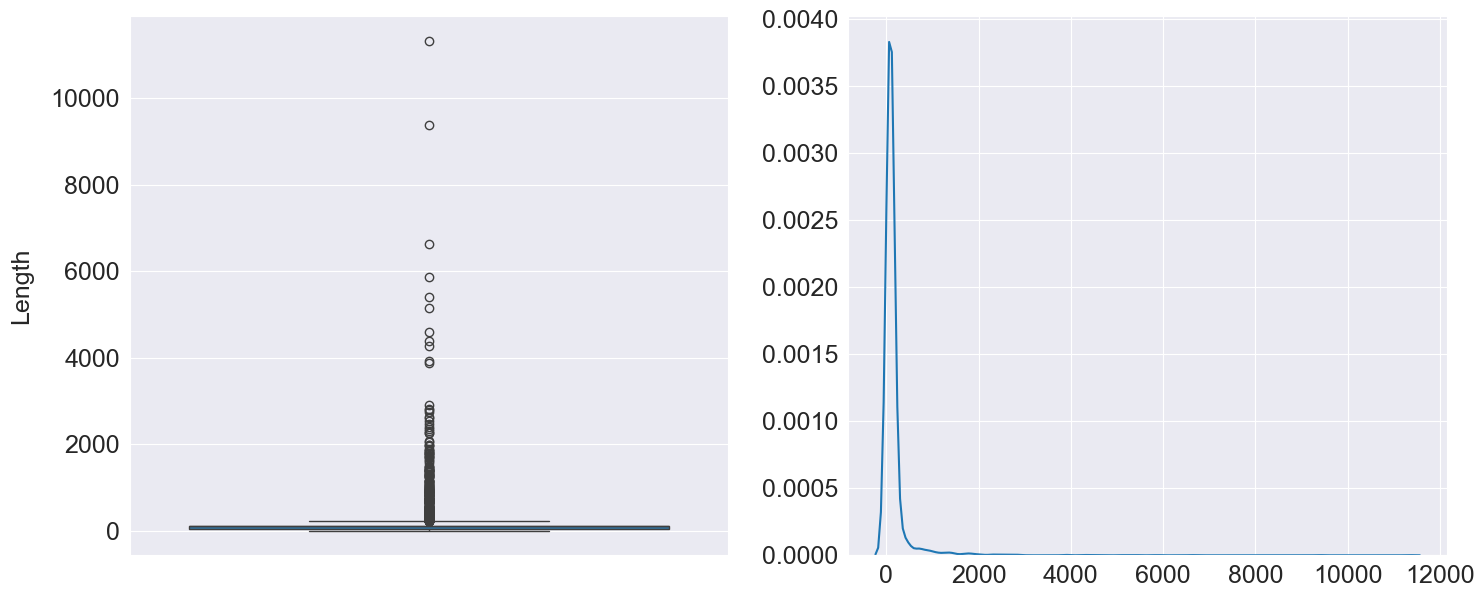

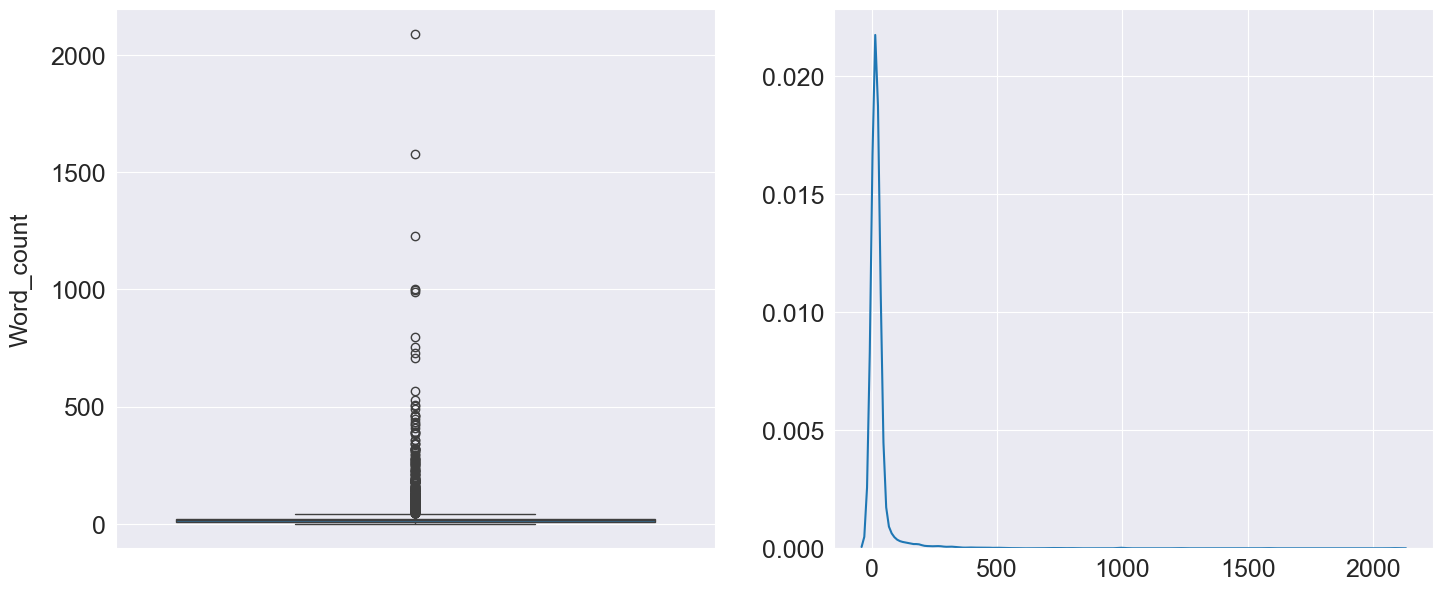

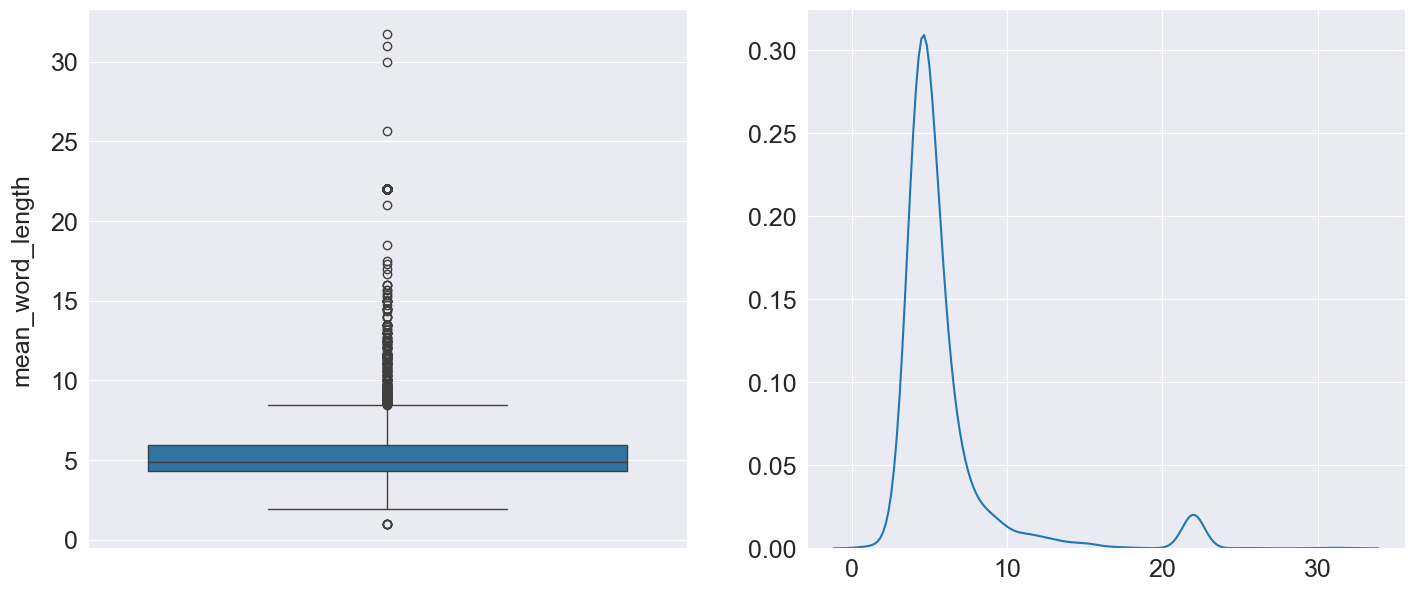

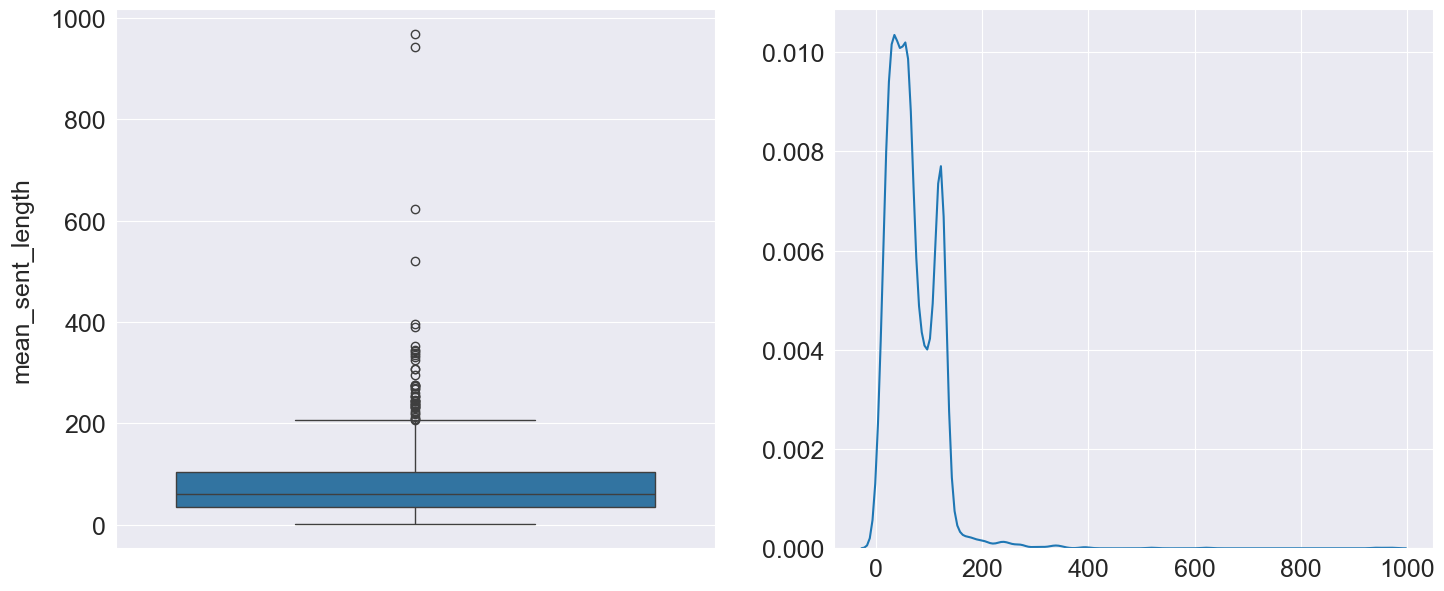

In [27]:
def visualize(col):
    
    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=df[col])
    plt.ylabel(col, labelpad=12.5)
    
    plt.subplot(1,2,2)
    sns.kdeplot(df[col])
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()
    
df.dropna(inplace= True)

features = df.columns.tolist()[2:]
for feature in features:
    visualize(feature)